# Data challenge

This notebook is a mash-up of useful commands and a first data analysis for the challenge.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk") # render your plot

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # scale variable
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
import numpy as np
from sklearn.tree import DecisionTreeRegressor

## Data loading and exploring

First steps are:
- loading the data;
- looking at the variables in the dataset, in particular, differentiate between numerical and categorical variables, which need different preprocessing in most machine learning workflows;
- visualizing the distribution of the variables to gain some insights into the dataset.\


(exploration is done on R)

Before building a machine learning model, it is a good idea to look at the data:

- maybe the task you are trying to achieve can be solved without machine learning;
- you need to check that the information you need for your task is actually present in the dataset;
- inspecting the data is a good way to find peculiarities. These can arise during data collection (for example, malfunctioning sensor or missing values), or from the way the data is processed afterwards (for example capped values).


In the data exploration part (R), MI column does not seem to be strongly associated with annual wages. And the number of years since job start seems less important than the job class for example. Will we recover this first impression while building a prediction algorithm?

In [2]:
salaries = pd.read_csv("./data/train_data.csv")

In [3]:
print(f"The dataset contains {salaries.shape[0]} samples and "
      f"{salaries.shape[1]} features")

The dataset contains 124727 samples and 15 features


## Prediction

In [4]:
target_name = 'ANNUAL'

In [5]:
REFERENCE_DATE = pd.to_datetime('02/01/21') # extraction date

def date_to_num(df_col):
    date = pd.to_datetime(df_col.squeeze())
    date[date > REFERENCE_DATE] -= pd.Timedelta('100Y')
    date_delta = REFERENCE_DATE - date
    return (date_delta.dt.days / 365).to_frame()

salaries[['HIREDT']] = date_to_num(salaries[['HIREDT']])

In [6]:
salaries["JC_TITLE_GRADE"] = salaries["JC TITLE"].str.split()
#salaries["JC_TITLE_SHORT"] = [" ".join(itm[0:-1]) for itm in salaries["JC_TITLE_GRADE"] if len(itm)>0]
salaries["JC_TITLE_GRADE"] = [itm[-1] for itm in salaries["JC_TITLE_GRADE"] if len(itm)>0]
salaries["JC_TITLE_GRADE"].unique()

array(['III', 'I', 'IV', 'OFFICER', 'II', 'STAFF', 'V', 'VI', 'RETIRED',
       'OIG', 'PROFESSIONAL', 'COORDINATOR', 'VII', 'JUDGE', 'OFFCRS',
       'TROOPER', 'OFFICIAL/ADMINISTRATOR', 'DPS', 'WARDEN', 'MEMBERS',
       'OFF', 'SPECIALIST', 'AGENT', 'SUPPORT', 'CORPORAL', 'COACHES',
       'JUSTICE', 'ASST', 'OFFICIAL', 'TRAINEE', 'ATTORNEY', 'ACTIVE',
       'OFFICE', 'TEACHER,PRINCIPALS,SUPERVISORS', 'DIRECTOR',
       'ASSISTANT', 'RPTR', 'TDI', 'ANALYST', 'RECEPTIONIST', 'ACCOUNTS',
       'SPRVSR', 'HOURLY/SUBSTITUTES', 'SPEC', 'PARAPROFESSIONAL',
       'WORKERS', 'SUPT', 'TABC', 'COUNSEL', 'SUPERVISOR', 'REPRES',
       'COMPACT', 'MANAGER', 'MEMBER', 'GENERAL', 'RVWR/EDITOR',
       'ENGINEER', 'IIII', 'C', 'INF', '11', 'ASSOC', 'COURT',
       'INVESTIGATOR', 'INVESTMENTS', 'LEADER', 'AUDITOR', 'DSHS',
       'FORMER', 'TEAM', 'TECHNICIAN', 'REPRESENTATIVE', 'EDITOR', 'LEAD',
       'ACTUARY', 'CENTER', 'SUPERINTENDENT', 'AIDE', 'COMMISSIONER',
       'BARBER/COSMETOLOGIST'

In [7]:
def treat_JCTITLE_column(row):
    if row['JC_TITLE_GRADE'] == "I":
        val = 1
    elif row['JC_TITLE_GRADE'] == "II":
        val = 2
    elif row['JC_TITLE_GRADE'] == "III":
        val = 3
    elif row['JC_TITLE_GRADE'] == "IIII":
        val = 4
    elif row['JC_TITLE_GRADE'] == "IV":
        val = 4
    elif row['JC_TITLE_GRADE'] == "V":
        val = 5
    elif row['JC_TITLE_GRADE'] == "VI":
        val = 6
    elif row['JC_TITLE_GRADE'] == "VII":
        val = 7
    else:
        val = -1
    return val

salaries["JC_TITLE_GRADE"] = salaries.apply(treat_JCTITLE_column, axis=1)
salaries["JC_TITLE_GRADE"]

0         3
1         1
2         4
3        -1
4         2
         ..
124722    7
124723    2
124724    3
124725    3
124726    2
Name: JC_TITLE_GRADE, Length: 124727, dtype: int64

In [8]:
salaries["JC_TITLE_SHORT"]

KeyError: 'JC_TITLE_SHORT'

In [9]:
salaries.dtypes

Unnamed: 0                   int64
RATE                       float64
HRSWKD                     float64
STATENUM                     int64
multiple_full_time_jobs    float64
NAME                        object
MI                          object
JOBCLASS                    object
JC TITLE                    object
RACE                        object
SEX                         object
EMPTYPE                     object
HIREDT                     float64
combined_multiple_jobs     float64
ANNUAL                     float64
JC_TITLE_GRADE               int64
dtype: object

In [10]:
# column type
numerical_columns = ['RATE', 'HRSWKD','HIREDT', "JC_TITLE_GRADE"]
categorical_columns = ['EMPTYPE', 'RACE', 'NAME', 'MI', 'JOBCLASS', 'SEX', 'JC TITLE'] #  'JC_TITLE_SHORT'
#categorical_columns = ['EMPTYPE', 'RACE', 'MI'] # to run faster the model 'JC TITLE', 'JOBCLASS', 'STATENUM',

X_salaries, target = salaries.drop(columns = target_name), salaries[target_name]

X_salaries_numeric = X_salaries[numerical_columns]
X_salaries_categorical = X_salaries[categorical_columns]

# list the categories
categories = [salaries[column].unique()
              for column in categorical_columns]

The standard deviation of the target is: 25563.54 k$


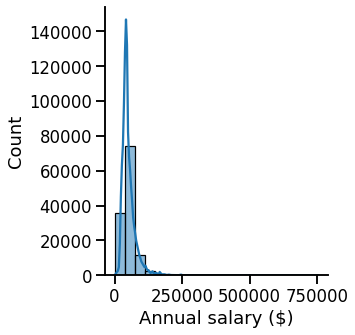

In [11]:
sns.displot(target, kde=True, bins=20)
_ = plt.xlabel("Annual salary ($)")
print(f"The standard deviation of the target is: {target.std():.2f} k$")

In [12]:
X_salaries["NAME"].value_counts()

HEALTH AND HUMAN SERVICES COMMISSION                  30069
TEXAS DEPARTMENT OF CRIMINAL JUSTICE                  29491
DEPARTMENT OF FAMILY AND PROTECTIVE SERVICES          10804
TEXAS DEPARTMENT OF TRANSPORTATION                    10555
DEPARTMENT OF PUBLIC SAFETY                            8656
                                                      ...  
HEALTH PROFESSIONS COUNCIL                                7
TEXAS EMERGENCY SERVICES RETIREMENT SYSTEM                7
COMPTROLLER OF PUBLIC ACCOUNTS, STATE ENERGY CONSE        6
BOARD OF PROFESSIONAL GEOSCIENTISTS                       4
OFFICE OF STATE PROSECUTING ATTORNEY                      3
Name: NAME, Length: 111, dtype: int64

We see that some categories are occuring rarely. This will be a problem during cross-validation: if the sample ends up in the test set during splitting then the classifier would not have seen the category during training and will not be able to encode it. Therefore we have to put a correct parameter in the Pipeline.

In [13]:
# choose data preprocessing
categorical_preprocessor = OneHotEncoder(categories=categories,
                                         drop="if_binary")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

linear_model = make_pipeline(preprocessor, LinearRegression())

In [14]:
scores = cross_val_score(linear_model, X_salaries, target)
scores

array([0.9303963 , 0.93640755, 0.9385869 , 0.91941501, 0.92077971])

In [60]:
set_config(display='diagram')
linear_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(categories=[array(['CRF - CLASSIFIED REGULAR FULL-TIME      ',
       'URF - UNCLASSIFIED REGULAR FULL-TIME    ',
       'CRP - CLASSIFIED REGULAR PART-TIME      ',
       'URP - UNCLASSIFIED REGULAR PART-TIME    ',
       'ERF - EXEMPT REGULAR FULL-TIME          ',
       'CTF - CLASSIFIED TEMPORARY FULL-TIME    ',
       'CTP - CLASSIFIED TEMPORARY PART-...
       'EXEC DIRECTOR, VETERANS', "COMMISSIONER OF WORKERS'",
       'SR INV ASSOCIATE,', 'EXECUTIVE DIRECTOR FOR',
       'MGR QUALITY CONTROL'], dtype=object),
                                                                            array(['MALE           ', 'FEMALE         '], dtype=object)],
                                                                drop='if_binary'),
                                                  ['EMPTYPE', 'RACE', 'NAME',
                                                   'MI', 'JOBCLASS',
                                                   'JC_TITLE_SHORT', 'SEX']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['RATE', 'HRSWKD', 'HIREDT',
                                                   'JC_TITLE_GRADE'])])),
                ('linearregression', LinearRegression())])

We recall that LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Note that this model is performing pretty well on this data set!

Can we expect a better score with a more powerful model?

In [114]:
# arbitrary integer coding of categories is perfectly fine for histgradient boosting
categorical_preprocessor = OrdinalEncoder(categories=categories) 

# just in case - this command line for onehotencoder
# categorical_preprocessor = OneHotEncoder(categories=categories, sparse=False) # force the use a dense representation as a workaround

new_preprocessor = ColumnTransformer([
    ('categorical', categorical_preprocessor, categorical_columns)],
    remainder="passthrough")

more_complex_model = make_pipeline(new_preprocessor, HistGradientBoostingRegressor())
scores = cross_val_score(more_complex_model, X_salaries, target)
scores

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 121, in fit
    X, y = self._validate_data(X, y, dtype=[X_DTYPE],
  File "/usr/local/lib/python3.9/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
 

array([nan, nan, nan, nan, nan])

Surprisingly we have a lower performance than the linear model. Does this come from overfitting?

In [88]:
def investigate_empirical_true_error(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 27)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    score = mean_absolute_error(y_pred, y_train)
    print(f"The empirical error of our model is {score:.2f} k$")
    y_pred = model.predict(X_test)
    score = mean_absolute_error(y_pred, y_test)
    print(f"The generalization error of our model is {score:.2f} k$")
    return

In [89]:
investigate_empirical_true_error(X_salaries, target, more_complex_model)
investigate_empirical_true_error(X_salaries, target, linear_model)

ValueError: could not convert string to float: 'PAROLE OFFCR II                                   '

Apparently not.

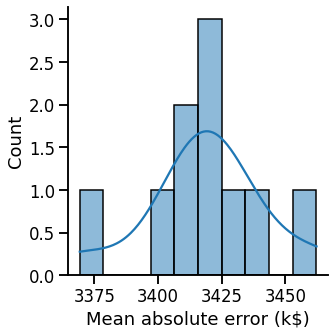

In [43]:
cv = ShuffleSplit(n_splits=10, test_size=0.2)
cv_results = cross_validate(linear_model, X_salaries, target, cv=cv, scoring="neg_mean_absolute_error")
cv_results = pd.DataFrame(cv_results)
cv_results["test_error"] = -cv_results["test_score"]

sns.set_context("talk")  # Set Seaborn's plotting style to "talk" mode.

sns.displot(cv_results["test_error"], kde=True, bins=10)
_ = plt.xlabel("Mean absolute error (k$)")

The mean estimate of the generalization error obtained by cross-validation is lower than the natural scale of variation of the target estimate.

In [47]:
# sandbox
toto = ["a", "b", "c"]
" ".join(toto)

'a b c'

In [115]:
salaries["JC TITLE"]

0         SECURITY OFFICER III                          ...
1         CHILD PROTECTIVE SVCS SPEC I                  ...
2         ENGINEER IV                                   ...
3         STATE PARK POLICE OFFICER                     ...
4         TEXAS WORKS ADVISOR II                        ...
                                ...                        
124722    ACCOUNTANT VII                                ...
124723    PAROLE OFFCR II                               ...
124724    APPRAISER III                                 ...
124725    ADMINISTRATIVE ASST III                       ...
124726    CUSTOMER SERVICE REP II                       ...
Name: JC TITLE, Length: 124727, dtype: object